In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


# Load raw Netflix dataset
df = pd.read_csv("C:/Users/Ayush Jindal/OneDrive/Desktop/Netflix Churn rate Prediction/netflix_churn.csv")

In [13]:
df.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


In [14]:
# Features and target
X = df.drop("churned", axis=1)
y = df["churned"]

# Identify columns
numeric_cols = ["age", "watch_hours", "last_login_days","number_of_profiles","avg_watch_time_per_day"]
categorical_cols = ["gender","device","favorite_genre","payment_method","region","subscription_type"]
ordinal_cols = ["subscription_type"]  # if there is an order, e.g., Basic < Standard < Premium
df.drop("monthly_fee",axis=1)

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,1,Crypto,2,0.13,Action
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,44f3ba44-b95d-4e50-a786-bac4d06f4a43,19,Female,Basic,49.17,11,Europe,Desktop,0,Credit Card,4,4.10,Drama
4996,18779bcb-ba2b-41da-b751-e70b812061ec,67,Female,Basic,9.24,2,North America,Desktop,0,PayPal,3,3.08,Documentary
4997,3f32e8c5-615b-4a3b-a864-db2688f7834f,66,Male,Standard,16.55,49,South America,Desktop,1,Debit Card,2,0.33,Action
4998,7b0ad82d-6571-430e-90f4-906259e0e89c,59,Female,Basic,9.12,3,Europe,Laptop,0,Credit Card,4,2.28,Sci-Fi


In [15]:
# 1. Missing Value Handler
class MissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        # Store median for numeric columns
        self.num_median = X[self.numeric_cols].median()
        # Store mode for categorical columns
        self.cat_mode = X[self.categorical_cols].mode().iloc[0]
        return self

    def transform(self, X):
        X = X.copy()
        # Fill numeric missing values with median
        X[self.numeric_cols] = X[self.numeric_cols].fillna(self.num_median)
        # Fill categorical missing values with mode
        X[self.categorical_cols] = X[self.categorical_cols].fillna(self.cat_mode)
        return X

In [16]:
# 2. Outlier Handler
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, cols, lower=0.01, upper=0.99):
        self.cols = cols
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        self.bounds = {}
        for col in self.cols:
            self.bounds[col] = (
                np.quantile(X[col], self.lower),
                np.quantile(X[col], self.upper)
            )
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            low, high = self.bounds[col]
            X[col] = np.clip(X[col], low, high)
        return X

In [17]:
# 1. Feature Engineering Transformer
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        X = X.copy()
        # Inactive flag: 1 if last_login_days > 30
        X["inactive_flag"] = X["last_login_days"].apply(lambda x: 1 if x > 30 else 0)
        # Engagement ratio: watch_hours / (last_login_days + 1)
        X["engagement_ratio"] = X["watch_hours"] / (X["last_login_days"] + 1)
        return X

# 2. Ordinal Encoding for subscription_type
ordinal_categories = [["Basic", "Standard", "Premium"]]  # specify order
ordinal_transformer = OrdinalEncoder(categories=ordinal_categories)

# 3. One-Hot Encoding for gender
onehot_transformer = OneHotEncoder(handle_unknown="ignore")

# 4. Column Transformer combining all
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_cols),                  # scale numeric columns
    ("ord", ordinal_transformer, ["subscription_type"]),      # ordinal encoding
    ("cat", onehot_transformer, ["gender","device","favorite_genre","payment_method","region","subscription_type"])                  # one-hot encoding
])

df.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


In [18]:
from sklearn.ensemble import RandomForestClassifier

# 1. Build the full pipeline
pipeline = Pipeline(steps=[
    ("missing_handler", MissingValueHandler(numeric_cols=numeric_cols, categorical_cols=categorical_cols)),
    ("outlier_handler", OutlierClipper(numeric_cols)),
    ("feature_engineering", FeatureEngineer()),
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=100, random_state=42))
])

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train the pipeline on raw data
pipeline.fit(X_train, y_train)

# 4. Test with a sample input
sample_input = pd.DataFrame([{
    "age": 28,
    "gender": "Male",
    "subscription_type": "Standard",
    "watch_hours": 20,
    "last_login_days": 45,
    "region": "Africa",
    "device":"TV",
    "payment_method":"Gift Card",
    "number_of_profiles":2,
    "avg_watch_time_per_day":.49,
    "favorite_genre":"Action"
    
}])

pred = pipeline.predict(sample_input)
prob = (pipeline.predict_proba(sample_input)[:, 1])*100

#print("Churn Prediction (0=Not churn,1=Churn):", pred)
print("Churn Probability: {:.1f}%".format(prob[0]))
# 5. Save pipeline for Streamlit deployment
joblib.dump(pipeline, "NetflixChurn_pipeline.pkl")


Churn Probability: 47.0%


['NetflixChurn_pipeline.pkl']

In [10]:
sample_input = pd.DataFrame([{
    "age": 18,
    "gender": "Male",
    "subscription_type": "Standard",
    "watch_hours": 10,
    "last_login_days": 45,
    "region": "Africa",
    "device":"TV",
    "payment_method":"Gift Card",
    "number_of_profiles":2,
    "avg_watch_time_per_day":.49,
    "favorite_genre":"Action"
    
}])

pred = pipeline.predict(sample_input)
prob = pipeline.predict_proba(sample_input)[:, 1]*100

#print("Churn Prediction (0=Not churn,1=Churn):", pred)
print("Churn Probability: {:.1f}%".format(prob[0]))

Churn Probability: 64.0%


Model Accuracy: 97.50%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       498
           1       0.98      0.97      0.97       502

    accuracy                           0.97      1000
   macro avg       0.98      0.98      0.97      1000
weighted avg       0.98      0.97      0.97      1000



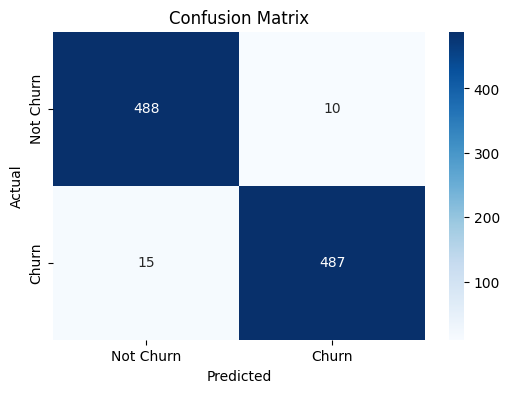

In [19]:
# Predict on test set
y_pred = pipeline.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy*100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


C:\Users\Ayush Jindal\AppData\Local\Temp\ipykernel_38356\1824354534.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette="viridis")


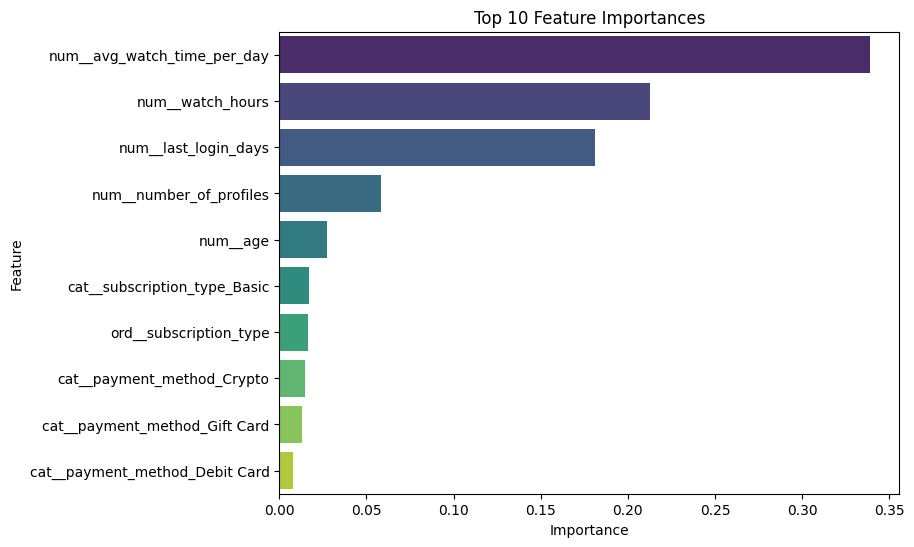

In [22]:
# Get trained model from pipeline
model = pipeline.named_steps['model']

# Get processed feature names
try:
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
except:
    feature_names = numeric_cols + categorical_cols

# Create importance dataframe
importances = model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance and take top 10
top_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

# Plot Top 10 Features
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette="viridis")
plt.title("Top 10 Feature Importances")
plt.show()


ROC-AUC Score: 0.998


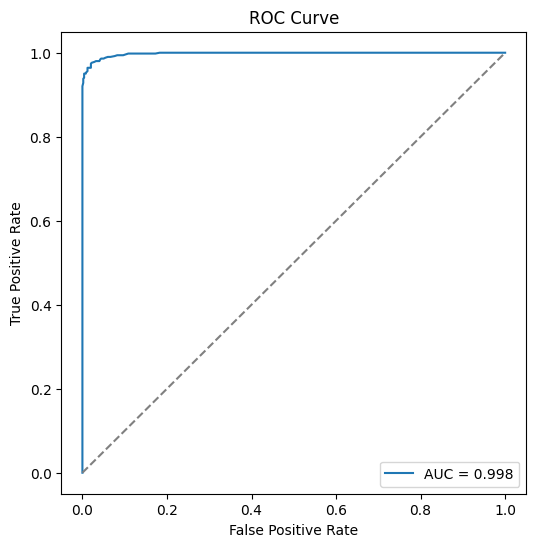

In [24]:
# Get prediction probabilities for the positive class (churn=1)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.3f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [25]:
# After you already created top_features DataFrame
print("Top Features Driving Churn:\n")
for i, row in top_features.iterrows():
    feature = row['Feature']
    importance = row['Importance']
    
    # Add simple business explanations
    if "last_login_days" in feature:
        explanation = "Customers inactive for longer are more likely to churn."
    elif "avg_watch_time_per_day" in feature:
        explanation = "Lower daily engagement often signals churn risk."
    elif "subscription_type" in feature:
        explanation = "Basic/low-tier subscribers may churn due to dissatisfaction."
    elif "region" in feature:
        explanation = "Churn patterns vary by region due to cultural preferences."
    elif "device" in feature:
        explanation = "Device usage can show loyalty—TV users may be more consistent."
    elif "payment_method" in feature:
        explanation = "Gift card users might not renew, while auto-pay users are stickier."
    else:
        explanation = "This feature contributes to predicting churn."
    
    print(f"- {feature}: {explanation} (Importance = {importance:.3f})")


Top Features Driving Churn:

- num__avg_watch_time_per_day: Lower daily engagement often signals churn risk. (Importance = 0.339)
- num__watch_hours: This feature contributes to predicting churn. (Importance = 0.213)
- num__last_login_days: Customers inactive for longer are more likely to churn. (Importance = 0.181)
- num__number_of_profiles: This feature contributes to predicting churn. (Importance = 0.058)
- num__age: This feature contributes to predicting churn. (Importance = 0.027)
- cat__subscription_type_Basic: Basic/low-tier subscribers may churn due to dissatisfaction. (Importance = 0.017)
- ord__subscription_type: Basic/low-tier subscribers may churn due to dissatisfaction. (Importance = 0.016)
- cat__payment_method_Crypto: Gift card users might not renew, while auto-pay users are stickier. (Importance = 0.015)
- cat__payment_method_Gift Card: Gift card users might not renew, while auto-pay users are stickier. (Importance = 0.013)
- cat__payment_method_Debit Card: Gift card us

In [29]:
# Define models for comparison
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}
results = []

for name, clf in models.items():
    # Build pipeline with preprocessing
    temp_pipeline = Pipeline(steps=[
        ("missing_handler", MissingValueHandler(numeric_cols=numeric_cols, categorical_cols=categorical_cols)),
        ("outlier_handler", OutlierClipper(numeric_cols)),
        ("feature_engineering", FeatureEngineer()),
        ("preprocessor", preprocessor),
        ("model", clf)
    ])
    
    # Train and evaluate
    temp_pipeline.fit(X_train, y_train)
    y_pred = temp_pipeline.predict(X_test)
    y_pred_proba = temp_pipeline.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results.append({"Model": name, "Accuracy": acc, "ROC-AUC": auc})

# Results DataFrame
results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy   ROC-AUC
0        Random Forest     0.975  0.997892
1  Logistic Regression     0.898  0.967355


<Figure size 800x500 with 0 Axes>

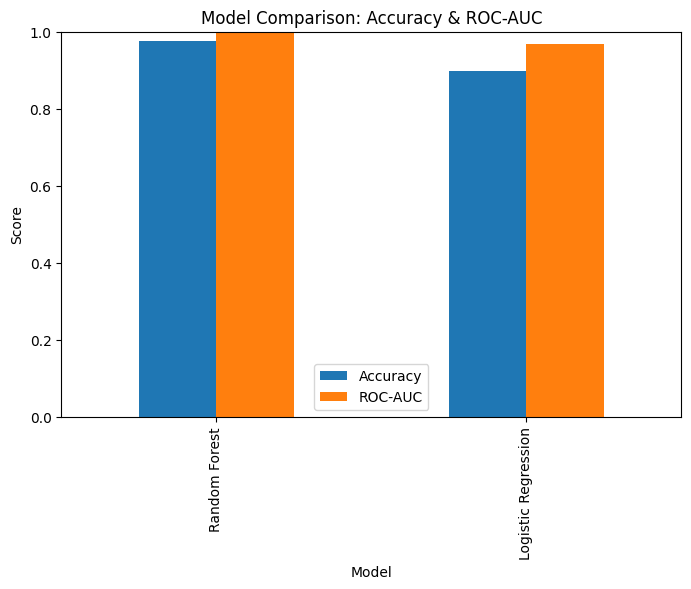

In [30]:
plt.figure(figsize=(8,5))
results_df.set_index("Model")[["Accuracy","ROC-AUC"]].plot(kind="bar", figsize=(8,5))
plt.title("Model Comparison: Accuracy & ROC-AUC")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()


In [32]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models to compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

In [33]:
results = []

for name, clf in models.items():
    # Build pipeline with preprocessing
    temp_pipeline = Pipeline(steps=[
        ("missing_handler", MissingValueHandler(numeric_cols=numeric_cols, categorical_cols=categorical_cols)),
        ("outlier_handler", OutlierClipper(numeric_cols)),
        ("feature_engineering", FeatureEngineer()),
        ("preprocessor", preprocessor),
        ("model", clf)
    ])
    
    # Cross-validation scores
    acc_scores = cross_val_score(temp_pipeline, X, y, cv=cv, scoring="accuracy")
    auc_scores = cross_val_score(temp_pipeline, X, y, cv=cv, scoring="roc_auc")
    
    results.append({
        "Model": name,
        "Accuracy Mean": acc_scores.mean(),
        "Accuracy Std": acc_scores.std(),
        "ROC-AUC Mean": auc_scores.mean(),
        "ROC-AUC Std": auc_scores.std()
    })

# Results DataFrame
cv_results_df = pd.DataFrame(results)
print(cv_results_df)


                 Model  Accuracy Mean  Accuracy Std  ROC-AUC Mean  ROC-AUC Std
0        Random Forest         0.9762      0.005492      0.997318     0.001426
1  Logistic Regression         0.8970      0.008579      0.967175     0.004018


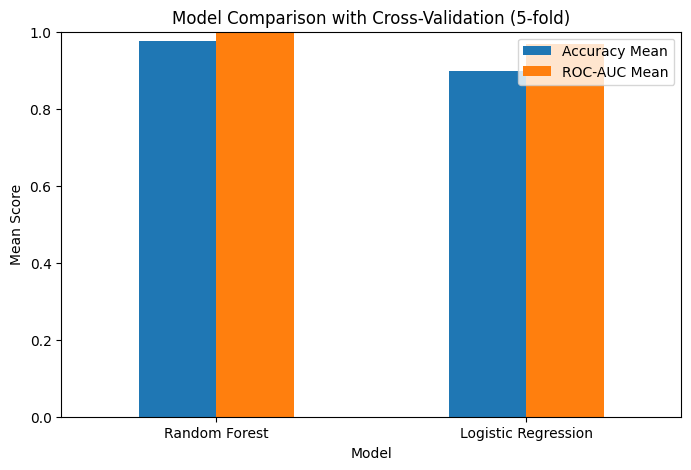

In [34]:
# Plot Accuracy and ROC-AUC means
cv_results_df.set_index("Model")[["Accuracy Mean","ROC-AUC Mean"]].plot(
    kind="bar", figsize=(8,5), rot=0
)
plt.title("Model Comparison with Cross-Validation (5-fold)")
plt.ylabel("Mean Score")
plt.ylim(0,1)
plt.show()
